# 2D Ferromagnetic Ising on a PBC Square Lattice

$$H = -J\sum_{\langle ij\rangle} \sigma_i\sigma_j$$

By inspection, we see that the ground states of this system correspond to all spins pointing in the same direction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ising_animator import IsingAnimator
from abstract_ising import AbstractIsing

%matplotlib inline

In [2]:
class Ising2DPBC(AbstractIsing):
    def __init__(self, Nx, Ny, J=1.):
        self.J, self.Nx, self.Ny = J, Nx, Ny
        self.num_spins = self.Nx * self.Ny
        
        # initialize system at infinite temperature
        # i.e. spins are completely random and uncorrelated
        self.spins = 2*(np.random.rand(self.Nx, self.Ny) < 0.5) - 1
    
    def energy(self):
        """Returns the energy of the current spin configuration"""
        horizontal = np.sum(np.roll(self.spins, 1, axis=0) * self.spins)
        vertical = np.sum(np.roll(self.spins, 1, axis=1) * self.spins)

        total = -self.J * (horizontal + vertical)

        return total

    def energy_diff(self, i, j):
        """Returns the energy difference resulting from flipping the site at coordinates (i,j)"""
        # sum the nearest neighbour sites
        nn_sum = (
            self.spins[i-1, j] 
            + self.spins[(i+1) % self.Nx, j] 
            + self.spins[i, j-1] 
            + self.spins[i, (j+1) % self.Ny]
        )

        return 2 * self.J * self.spins[i, j] * nn_sum
    
    def rand_site(self):
        """Selects a site in the lattice at random"""
        i = np.random.randint(self.Nx)
        j = np.random.randint(self.Ny)
        return i, j
    

In [3]:
ising = Ising2DPBC(10, 10, J=1)
ising.spins

array([[ 1, -1,  1,  1,  1, -1, -1,  1, -1, -1],
       [ 1,  1, -1, -1,  1, -1,  1, -1,  1,  1],
       [ 1,  1, -1, -1, -1, -1,  1, -1,  1, -1],
       [-1, -1, -1, -1,  1,  1,  1, -1, -1, -1],
       [-1,  1,  1, -1, -1,  1, -1, -1, -1,  1],
       [-1,  1, -1,  1, -1,  1,  1, -1,  1, -1],
       [ 1, -1,  1, -1, -1,  1,  1,  1,  1,  1],
       [ 1,  1, -1, -1, -1, -1, -1,  1,  1, -1],
       [-1, -1, -1,  1, -1,  1,  1,  1,  1,  1],
       [-1,  1,  1, -1,  1,  1,  1, -1, -1, -1]])

In [4]:
# perform 1000 MC steps
for t in range(1000):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=1.0)
    
    if t % 50 == 0:
        print(E)

-52
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200
-200


In [5]:
ising.spins

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [6]:
n_steps = 100
t = np.arange(n_steps+1)
T0 = 100
T_min = 0.01

T = T0 * ((T_min/T0) ** (t/n_steps))
T

array([1.00000000e+02, 9.12010839e+01, 8.31763771e+01, 7.58577575e+01,
       6.91830971e+01, 6.30957344e+01, 5.75439937e+01, 5.24807460e+01,
       4.78630092e+01, 4.36515832e+01, 3.98107171e+01, 3.63078055e+01,
       3.31131121e+01, 3.01995172e+01, 2.75422870e+01, 2.51188643e+01,
       2.29086765e+01, 2.08929613e+01, 1.90546072e+01, 1.73780083e+01,
       1.58489319e+01, 1.44543977e+01, 1.31825674e+01, 1.20226443e+01,
       1.09647820e+01, 1.00000000e+01, 9.12010839e+00, 8.31763771e+00,
       7.58577575e+00, 6.91830971e+00, 6.30957344e+00, 5.75439937e+00,
       5.24807460e+00, 4.78630092e+00, 4.36515832e+00, 3.98107171e+00,
       3.63078055e+00, 3.31131121e+00, 3.01995172e+00, 2.75422870e+00,
       2.51188643e+00, 2.29086765e+00, 2.08929613e+00, 1.90546072e+00,
       1.73780083e+00, 1.58489319e+00, 1.44543977e+00, 1.31825674e+00,
       1.20226443e+00, 1.09647820e+00, 1.00000000e+00, 9.12010839e-01,
       8.31763771e-01, 7.58577575e-01, 6.91830971e-01, 6.30957344e-01,
      

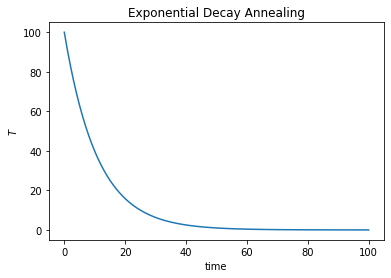

In [7]:
plt.plot(t, T)
plt.title("Exponential Decay Annealing")
plt.ylabel("$T$")
plt.xlabel("time");

[[ 1  1 -1 -1  1  1  1  1 -1 -1]
 [ 1 -1  1  1  1 -1  1 -1 -1  1]
 [-1  1 -1 -1 -1  1  1  1  1  1]
 [ 1  1  1 -1  1 -1 -1 -1  1  1]
 [-1 -1 -1 -1  1 -1  1 -1  1  1]
 [ 1  1 -1  1  1  1  1  1  1 -1]
 [-1 -1 -1 -1 -1  1  1  1 -1  1]
 [ 1  1  1 -1  1 -1  1 -1  1  1]
 [ 1  1  1  1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1  1 -1 -1  1  1]]


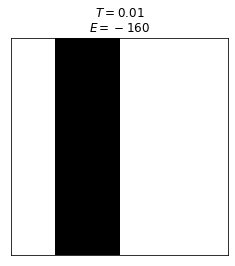

In [8]:
# reinitialize so we're back at a T=infinity state
ising = Ising2DPBC(10, 10, J=1)
print(ising.spins)  # print the starting configuration

# NOTE: sometimes the animation gets stuck displaying a single image
# The most reliable way to fix this is by restarting the notebook.
# Initializing the Ising Model in the same cell as the one where you
# run the animation also seems to work.
animator = IsingAnimator(ising)
animator.run_animation(T)

If the ground state was found, we should see the plot completely fill up with a single color. Since the 2D Ising Model is fairly simple, this happens quite often. In some cases however, we may see the formation of distinct domains, in which there is a straight line separating two domains of opposite spin. An example of this is shown in the video below:

In [9]:
from IPython.display import Video

Video("domain_wall.mp4")

States with domain separation correspond to local minima of the energy. Ideally, our annealer should be able to help us escape these local minima and find the global minimum (the ground state).